# 

In [1]:
%cd ..

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN


/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.bgn_st_tracking import GNNSegmentClassifier
from icecream import ic
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm
from itertools import islice

In [3]:
def get_track_endpoints(hits, good_layers):
    # Assumption: all tracks have at least 1 hit
    # If it has one hit, first_hit == last_hit for that track
    # hits shape: (n_tracks, 5, 3)
    # good_layers shape: (n_tracks, 5)
    min_indices = good_layers * np.arange(5) + (1 - good_layers) * np.arange(5, 10)
    indices = np.expand_dims(np.argmin(min_indices, axis=-1), -1)
    indices = np.expand_dims(indices, axis=-2)
    first_hits = np.take_along_axis(hits, indices, axis=-2)
    max_indices = good_layers * np.arange(5, 10) + (1 - good_layers) * np.arange(5)
    indices = np.expand_dims(np.argmax(max_indices, axis=-1), -1)
    indices = np.expand_dims(indices, axis=-2)
    last_hits = np.take_along_axis(hits, indices, axis=-2)
    return first_hits.squeeze(1), last_hits.squeeze(1)

def get_predicted_pz(track_hits, good_layers, radius):
    hits = track_hits.reshape(-1, 5, 3)
    first_hit, last_hit = get_track_endpoints(hits, good_layers)
    dz = (last_hit[:, -1] - first_hit[:, -1])/100
    chord2 = ((last_hit[:, 0] - first_hit[:, 0]) ** 2 + (last_hit[:, 1] - first_hit[:, 1]) ** 2) / 10000
    r2 = 2*radius**2
    with np.errstate(invalid='ignore'):
        dtheta = np.arccos((r2 - chord2) / (r2 + (r2 == 0)))
    dtheta += (dtheta == 0)
    return np.nan_to_num(dz / dtheta)

def matmul_3D(A, B):
    return np.einsum('lij,ljk->lik', A, B)


def get_approximate_radii(track_hits, good_layers, n_layers):
    x_indices = [3*j for j in range(5)]
    y_indices = [3*j+1 for j in range(5)]
    r = np.zeros(track_hits.shape[0])
    centers = np.zeros((track_hits.shape[0], 2))
    for n_layer in range(3, 5 + 1):
        complete_tracks = track_hits[n_layers == n_layer]
        hit_indices = good_layers[n_layers == n_layer]
        if complete_tracks.shape[0] == 0:
            continue

        A = np.ones((complete_tracks.shape[0], n_layer, 3))
        x_values = complete_tracks[:, x_indices]
        x_values = x_values[hit_indices].reshape(complete_tracks.shape[0], n_layer)

        y_values = complete_tracks[:, y_indices]
        y_values = y_values[hit_indices].reshape(complete_tracks.shape[0], n_layer)
        A[:, :, 0] = x_values
        A[:, :, 1] = y_values

        y = - x_values**2 - y_values**2
        y = y.reshape((y.shape[0], y.shape[1], 1))
        AT = np.transpose(A, axes=(0, 2, 1))
        c = matmul_3D(matmul_3D(inv(matmul_3D(AT, A)), AT), y)[..., 0]
        r[n_layers == n_layer] = np.sqrt(c[:, 0]**2 + c[:, 1]**2 - 4*c[:, 2])/200
        centers[n_layers == n_layer] = np.stack([-c[:, 0]/2, -c[:, 1]/2], axis=-1)

    #test = get_approximate_radius(track_hits, n_layers == 5)
    #assert np.allclose(test, r[n_layers == 5])

    return r, centers

def get_length(start, end):
    return np.sqrt(np.sum((start - end)**2, axis=1))


def port_event(batch, batch_output, ip_output, trigger_output, output_file):
    """
    Ported function to construct track_hits from batch.x_intt, batch.x_mvtx, and batch.edge_index.
    
    Parameters:
      batch: an object with attributes:
            - x_intt: shape (N, 10) [each row has two hits, each hit with (r, phi, z, layer_id, n_pixels)]
            - x_mvtx: shape (M, 5) [each row is (r, phi, z, layer_id, n_pixels)]
            - edge_index: shape (2, num_edges) linking x_intt indices (first row) to x_mvtx indices (second row)
            - interaction_point: an iterable giving the true interaction point (e.g. [x, y, z])
            - trigger: a boolean flag for trigger
      batch_output: predictions for the edges (use batch_output > 0 to decide if an edge is “true”)
      ip_output: model’s predicted interaction point (to be saved as interaction_point_pred)
      trigger_output: model’s predicted trigger output (to be saved as trigger_pred)
      output_file: destination path for the npz output file.
    """
    # Mapping from raw layer_id to track layer (0-indexed):
    # 0 -> 0, 1 -> 1, 2 -> 2, 3 -> 3, 4 -> 3, 5 -> 4, 6 -> 4.
    layer_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 4}
    
    x_intt = batch.x_intt.detach().cpu().numpy()   # shape (N, 10)
    x_mvtx = batch.x_mvtx.detach().cpu().numpy()    # shape (M, 5)
    edge_index = batch.edge_index  # shape (2, num_edges)
    
    num_tracks = x_intt.shape[0]
    # Prepare an array to hold the track vectors: 5 layers x 3 coordinates = 15 per track.
    track_hits = np.zeros((num_tracks, 15), dtype=np.float32)
    
    # Create a mapping from each x_intt hit (track candidate) to the list of associated x_mvtx indices.
    # We assume edge_index[0] contains indices into x_intt and edge_index[1] indices into x_mvtx.
    track_to_mvtx = {i: [] for i in range(num_tracks)}
    
    # Filter edge_index based on the mask (true edges: batch_output > 0)
    true_mask = batch_output > 0
    true_edges = edge_index[:, true_mask]  # shape (2, num_true_edges)
    
    # Group associated mvtx indices by their corresponding intt index.
    for intt_idx, mvtx_idx in zip(true_edges[0], true_edges[1]):
        intt_idx = int(intt_idx)
        mvtx_idx = int(mvtx_idx)
        track_to_mvtx[intt_idx].append(mvtx_idx)
    
    # Process each track (each row in x_intt)
    for i in range(num_tracks):
        # Dictionary to collect (x,y,z) hits for each track layer (0 through 4).
        hits_per_layer = {layer: [] for layer in range(5)}
        
        # --- Process the two hits from x_intt ---
        # First hit: entries 0 to 4.
        hit1 = x_intt[i,  [0, 1, 2, 6, 8]]  # (r, phi, z, layer_id, n_pixels)
        r, phi, z, _, layer_id = hit1
        r *= 3
        z *= 3
        x_coord = r * np.cos(phi)
        y_coord = r * np.sin(phi)
        mapped_layer = layer_map[int(layer_id)]
        hits_per_layer[mapped_layer].append([x_coord, y_coord, z])
        
        # Second hit: entries 5 to 10.
        hit2 = x_intt[i, [3, 4, 5, 7, 9]]
        r, phi, z, _, layer_id = hit2
        r *= 3
        z *= 3
        x_coord = r * np.cos(phi)
        y_coord = r * np.sin(phi)
        mapped_layer = layer_map[int(layer_id)]
        hits_per_layer[mapped_layer].append([x_coord, y_coord, z])
        
        # --- Process associated x_mvtx hits ---
        for mvtx_idx in track_to_mvtx[i]:
            hit = x_mvtx[mvtx_idx]  # shape (5,)
            r, phi, z, _, layer_id = hit
            r *= 3
            z *= 3
            x_coord = r * np.cos(phi)
            y_coord = r * np.sin(phi)
            mapped_layer = layer_map[int(layer_id)]
            hits_per_layer[mapped_layer].append([x_coord, y_coord, z])
        
        # --- Average hits per layer ---
        # The track vector is arranged as:
        # [layer0_x, layer0_y, layer0_z, layer1_x, layer1_y, layer1_z, ..., layer4_x, layer4_y, layer4_z]
        for layer in range(5):
            if hits_per_layer[layer]:
                # Compute the mean coordinate for this layer.
                avg_coord = np.mean(np.array(hits_per_layer[layer]), axis=0)
                track_hits[i, 3*layer:3*layer+3] = avg_coord
            # If no hits exist for a layer, the corresponding entries remain 0.
    
    # --- Compute helper variables ---
    # Reshape to (num_tracks, 5, 3) and create a boolean mask indicating which layers have at least one hit.
    good_layers = np.any(track_hits.reshape(num_tracks, 5, 3) != 0, axis=-1)
    n_layers = np.sum(good_layers, axis=-1)
    
    # Use batch.interaction_point (the true collision vertex) for output.
    ip = tuple(float(x) for x in batch.interaction_point[0])
    
    # Call the helper functions (assumed to be implemented elsewhere)
    radii, centers = get_approximate_radii(track_hits, good_layers, n_layers)
    p_z = get_predicted_pz(track_hits, good_layers, radii)
    
    # --- Save output ---
    # Save the numpy file with the required keys. Note that we are not shuffling the tracks.
    np.savez(
        output_file,
        collision_vertex=ip,
        tracks=track_hits,
        radii=radii,
        p_z=p_z,
        centers=centers,
        trigger=batch.trigger.cpu().numpy()[0],
        trigger_pred=trigger_output.detach().cpu().numpy(),
        interaction_point_pred=ip_output.detach().cpu().numpy()
    )


In [4]:
DEVICE = "cuda:0"

In [5]:
# create model and load checkpoint
model_result_folder = '/disks/disk1/giorgian/old-trainings//tracking_results/agnn/agnn-lr0.0008127498598898657-b24-d64-PReLU-gi1-ln-False-n50000/experiment_2025-03-25_09:52:45/'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')

model_config = config.get('model', {})
model_config.pop('loss_func')
model_config.pop('name')
model = GNNSegmentClassifier(**model_config).to(DEVICE)

def load_checkpoint(checkpoint_file, model, optimizer=None):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

# load_checkpoint
checkpoint_dir = os.path.join(model_result_folder, 'checkpoints')
checkpoint_file = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')])
checkpoint_file = checkpoint_file[-1]
print(checkpoint_file)
model = load_checkpoint(checkpoint_file, model)
print('Successfully reloaded!')

/disks/disk1/giorgian/old-trainings//tracking_results/agnn/agnn-lr0.0008127498598898657-b24-d64-PReLU-gi1-ln-False-n50000/experiment_2025-03-25_09:52:45/checkpoints/model_checkpoint_017.pth.tar
Successfully reloaded!


/tmp/ipykernel_1003450/3142262820.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))


In [6]:
data_config['batch_size'] = 1
data_config['n_train'] = 1
data_config['n_valid'] = 34000
data_config['load_full_event'] = True
data_config['n_workers'] = 1
data_config['apply_constraints'] = True
#data_config['input_dir2'] = '/ssd1/giorgian/hits-data-august-2022-ctypes/trigger/1'
#data_config['force_inputdir2_nontrigger'] = True

In [7]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)


In [8]:
batch.particle_id

NameError: name 'batch' is not defined

In [8]:
for batch in tqdm(valid_data_loader):
    # Run the model to get predictions
    batch = batch.to(DEVICE)
    batch_output, ip_output, trigger_output = model(batch)
    
    for particle_id  in torch.unique(batch.particle_id_intt):
        new_batch = batch.clone()
        intt_mask = batch.particle_id_intt != particle_id
        mvtx_mask = batch.particle_id_mvtx != particle_id
        new_batch.x_intt = new_batch.x_intt[intt_mask]
        new_batch.x_mvtx = new_batch.x_mvtx[mvtx_mask]
        new_batch.batch_intt = new_batch.batch_intt[intt_mask]
        new_batch.batch_mvtx = new_batch.batch_mvtx[mvtx_mask]
        keep_intt = (torch.isin(new_batch.edge_index_intt[0], torch.where(intt_mask)[0])) & (torch.isin(new_batch.edge_index_intt[1], torch.where(intt_mask)[0]))
        keep_mvtx = (torch.isin(new_batch.edge_index[0], torch.where(intt_mask)[0])) & (torch.isin(new_batch.edge_index[1], torch.where(mvtx_mask)[0]))

    break



  0%|          | 0/68000 [00:00<?, ?it/s]

np.sum(good_seg_mask)=np.int64(55) edges.shape=(2461, 2) edges[good_seg_mask.reshape(-1)].shape=(55, 2) phi_slope_max=0.012193355583173944 z0_max=14.220353082111805
np.sum(good_seg_mask)=np.int64(40) edges.shape=(3564, 2) edges[good_seg_mask.reshape(-1)].shape=(40, 2) phi_slope_max=0.012193355583173944 z0_max=14.220353082111805
np.sum(good_seg_mask)=np.int64(21) edges.shape=(1470, 2) edges[good_seg_mask.reshape(-1)].shape=(21, 2) phi_slope_max=0.012193355583173944 z0_max=14.220353082111805


In [10]:
r1, phi1, z1 = batch.x_mvtx[:, :3].T.cpu().numpy()
r2, phi2, z2 = batch.x_intt[:, :3].T.cpu().numpy()
r3, phi3, z3 = batch.x_intt[:, 3:6].T.cpu().numpy()

In [11]:
r1 *= 3
r2 *= 3
r3 *= 3
z1 *= 3
z2 *= 3
z3 *= 3

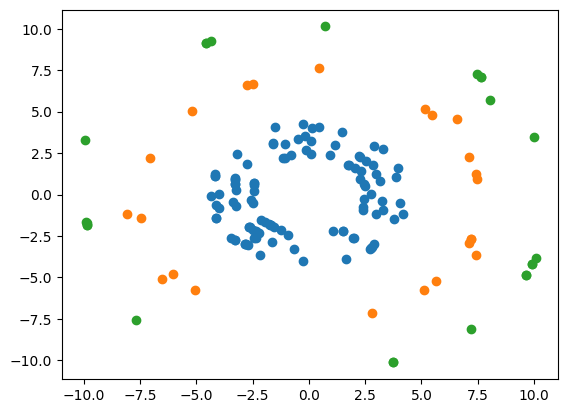

In [12]:
plt.scatter(r1*np.cos(phi1), r1*np.sin(phi1))
plt.scatter(r2*np.cos(phi2), r2*np.sin(phi2))
plt.scatter(r3*np.cos(phi3), r3*np.sin(phi3))

In [9]:
data_config['phi_slope_max']

0.012193355583173944

In [48]:
batch.edge_index.shape

torch.Size([2, 678])

In [43]:
batch.edge_index

tensor([[  1,   4],
        [  5, 110]], device='cuda:0')

In [35]:
keep_intt, keep_mvtx

(tensor([False, False, False, False, False, False,  True,  True,  True,  True,
         False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         False,  True,  True,  True,  True], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.bool))

In [41]:
batch

Data(edge_index=[2, 2], y=[2], x_intt=[4, 10], x_mvtx=[124, 5], trigger=[1], w=[2], trigger_node=[128], active_node=[131], i=0, filename=[1], interaction_point=[1, 3], event_info=[1], edge_index_intt=[2, 16], batch_intt=[4], batch_mvtx=[124], particle_id_intt=[4], particle_id_mvtx=[124])

In [31]:
keep = (torch.isin(new_batch.edge_index_intt[0], torch.where(intt_mask)[0])) & (torch.isin(new_batch.edge_index_intt[1], torch.where(intt_mask)[0]))

In [32]:
keep

tensor([False, False, False, False, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True], device='cuda:0')

In [33]:
batch.edge_index_intt

tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]], device='cuda:0')

In [30]:
batch.edge_index_intt

tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]], device='cuda:0')

In [26]:
torch.where(intt_mask)

(tensor([1, 2, 3], device='cuda:0'),)

In [27]:
intt_mask

tensor([False,  True,  True,  True], device='cuda:0')

In [21]:
new_batch.edge_index_intt

tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]], device='cuda:0')

In [24]:
new_batch

Data(edge_index=[2, 1], y=[1], x_intt=[3, 10], x_mvtx=[104, 5], trigger=[1], w=[1], trigger_node=[108], active_node=[112], i=0, filename=[1], interaction_point=[1, 3], event_info=[1], edge_index_intt=[2, 16], batch_intt=[4], batch_mvtx=[104], particle_id_intt=[4], particle_id_mvtx=[104])

In [15]:
batch.copy()

AttributeError: 'GlobalStorage' object has no attribute 'copy'

In [14]:
torch.unique(batch.particle_id_intt)

tensor([-2147483648,        -593,        -522], device='cuda:0',
       dtype=torch.int32)

In [16]:
batch.clone()

Data(edge_index=[2, 15], y=[15], x_intt=[9, 10], x_mvtx=[78, 5], trigger=[1], w=[15], trigger_node=[87], active_node=[93], i=0, filename=[1], interaction_point=[1, 3], event_info=[1], edge_index_intt=[2, 81], batch_intt=[9], batch_mvtx=[78], particle_id_intt=[9], particle_id_mvtx=[78])

In [11]:
mask = batch.event_info[0].particle_id == 55

In [12]:
batch.event_info[0].particle_type[mask]

array([211., 211., 211.])

In [18]:
batch.event_info[0].particle_id.shape

(206,)

In [19]:
batch.event_info[0].particle_type.shape

(307,)

In [ ]:
batch.event_info[0].particle_type

In [12]:
batch.event_info

Data(edge_index=[2, 9], y=[9], x_intt=[5, 10], x_mvtx=[68, 5], trigger=[1], w=[9], trigger_node=[73], active_node=[79], i=0, filename=[1], interaction_point=[1, 3], edge_index_intt=[2, 25], batch_intt=[5], batch_mvtx=[68])

In [ ]:
trigger_output

In [61]:
batch.interaction_point

tensor([[1.5534e-02, 1.2005e-03, 4.0199e+01]], device='cuda:0')